## predict the validset, and analyse

In [ ]:
#move checkpoint from gamma machine to here
cd checkpoint
scp -r endi.niu@10.171.36.214:/home/endi.niu/SIIM/checkpoint/deeplabv3plus_resnet_768_v1_seed1234/ deeplabv3plus_resnet_768_v1_seed1234
cd logging
scp -r endi.niu@10.171.36.214:/home/endi.niu/SIIM/logging/deeplabv3plus_resnet_768_v1_seed1234.log deeplabv3plus_resnet_768_v1_seed1234.log

In [8]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook
import pickle
import os
import logging
import time
import gc
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device


from model.model_unet_classify_zero import UNetResNet34 as Classifier
from model.model_unet_classify_zero import predict_proba as clf_predict_proba
#from dataset_NIH import prepare_trainset as prepare_trainset_NIH

from model.deeplab_model_kaggler.deeplab import DeepLab
from model.deeplab_model_kaggler.deeplab import predict_proba as mask_predict_proba
from dataset_unet import prepare_trainset as prepare_trainset_kaggle

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(x):
    return np.log(x / (1-x))

%matplotlib inline

In [3]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'resnet'#
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = None#[0, 1]#use 2 gpus

SEED = 1234 #5678#4567#3456#2345#1234
debug = False# if True, load 100 samples
IMG_SIZE = 768 #768#1024#512
BATCH_SIZE = 32 #32#16
NUM_WORKERS = 24
torch.cuda.manual_seed_all(SEED)

====MODEL ACHITECTURE: resnet====


In [4]:
train_dl, val_dl = prepare_trainset_kaggle(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

Count of trainset (for training):  9607
Count of validset (for training):  1068


In [6]:
# y should be makeup
y_valid = []
for i, (image, masks) in enumerate(val_dl):
    #if i==10:
    #    break
    truth = masks.to(device=device, dtype=torch.float)
    y_valid.append(truth.cpu().numpy())
y_valid = np.concatenate(y_valid, axis=0)
y_valid.shape

(1056, 1, 768, 768)

In [9]:
net = DeepLab(num_classes=2,
              backbone=MODEL,#resnet34, resnet101
              output_stride=16,#default 16, 8
              sync_bn=None,
              freeze_bn=False,
              debug=False
             ).cuda(device=device)

#checkpoint_path = 'checkpoint/deeplabv3plus_resnet_1024_v1_seed1234/best.pth.tar'
#checkpoint_path = 'checkpoint/deeplabv3plus_resnet_1024_v1_seed3456/best.pth.tar'
#checkpoint_path = 'checkpoint/deeplabv3plus_resnet_768_v1_seed3456/best.pth.tar'
#checkpoint_path = 'checkpoint/deeplabv3plus_resnet_768_v1_seed2345/best.pth.tar'
#checkpoint_path = 'checkpoint/deeplabv3plus_resnet_768_v1_seed1234/best.pth.tar'
#checkpoint_path = 'checkpoint/deeplabv3plus_resnet_1024_v1_seed2345/best.pth.tar'

checkpoint_path = 'checkpoint/deeplabv3plus_resnet_768_v1_seed1234/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)

#net = nn.DataParallel(net, device_ids=multi_gpu)

====USE ResNet101====


In [12]:
%%time
# predict_proba
net.set_mode('valid')#.module
preds_valid = mask_predict_proba(net, val_dl, device, multi_gpu=False, mode='valid', tta=True)

use TTA
CPU times: user 7min 14s, sys: 2min 10s, total: 9min 25s
Wall time: 2min 12s


In [13]:
y_valid.shape, preds_valid.shape

((1056, 1, 768, 768), (1056, 768, 768))

## load classifier model and predict on validset

In [14]:
clf = Classifier(debug=False).cuda(device=device)#UNetResNet34
checkpoint_path = 'checkpoint/nonzero_classifier_UNetResNet34_768_v1_seed1234/best.pth.tar'
clf, _ = load_checkpoint(checkpoint_path, clf)

In [15]:
%%time
# predict_proba
clf.set_mode('valid')#.module
preds_valid_clf = clf_predict_proba(clf, val_dl, device, multi_gpu=False, mode='valid', tta=True)

/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


CPU times: user 3min 56s, sys: 35 s, total: 4min 31s
Wall time: 1min 19s


In [109]:
#preds_valid_clf.shape
#((sigmoid(preds_valid_clf)>CLF_THRESHOLD).astype(np.int).reshape(-1,)==1).mean()
#y_valid_clf = (y_valid.reshape(y_valid.shape[0], -1).sum(axis=1)>0).astype(np.float)
#clf.criterion(torch.from_numpy(preds_valid_clf.reshape(-1,).astype(np.float)), torch.from_numpy(y_valid_clf))
cal_metric(preds_valid_clf.reshape(-1,), y_valid_clf)

(0.03693, 678, 142, 26, 210, 0.85833, 0.3333333333333333, 0.51)

In [108]:
## search for best thresholds
def calculate_dice(logit, truth, MASK_THRESHOLD=0.22, logit_clf=None, CLF_THRESHOLD=0.51):
    IMG_SIZE = logit.shape[-1] #256
    logit = sigmoid(logit)#.reshape(n, -1)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    #pred_clf = (pred.reshape(pred.shape[0], -1).sum(axis=1)<EMPTY_THRESHOLD).astype(np.int)
    pred_clf = (sigmoid(logit_clf)>CLF_THRESHOLD).astype(np.int)
    print('predict clf=1 percentage: ', round(pred_clf.mean(), 3))
    pred[pred_clf.reshape(-1,)==0, ] = 0
    return dice_overall(pred, truth)

def dice_overall(pred_mask, truth_mask, eps=1e-8):
    n = pred_mask.shape[0]
    pred_mask = pred_mask.reshape(n, -1)
    truth_mask = truth_mask.reshape(n, -1)
    intersect = (pred_mask * truth_mask).sum(axis=1).astype(np.float)
    union = (pred_mask + truth_mask).sum(axis=1).astype(np.float)
    return ((2.0*intersect + eps) / (union+eps)).mean()


from sklearn.metrics import roc_auc_score, confusion_matrix

def cal_metric(logit, truth):
    #pred = sigmoid(logit.cpu().detach())
    pred = sigmoid(logit)
    #truth = truth.cpu().detach()
    ##
    THRESHOLD_candidate = np.arange(0.01, 0.99, 0.01)#np.arange(0.1, 1.0, 0.1)
    N = len(THRESHOLD_candidate)
    best_threshold = None
    best_score = 9999
    tn, fp, fn, tp, auc, pos_percent = 0, 0, 0, 0, 0.0, 0.0
    for i in range(N):
        THRESHOLD = THRESHOLD_candidate[i]
        _pred = pred>THRESHOLD
        _tn, _fp, _fn, _tp = confusion_matrix(truth, _pred).ravel()
        _auc = round(roc_auc_score(truth, _pred), 5)
        if _tn+_fn==0:
            fn_rate = 9999
        else:
            fn_rate = round(_fn/(_tn+_fn), 5)
        #predict positive proportion should be ~28%
        _pos_percent = (_tp+_fp)/(_tp+_fp+_tn+_fn)
        if 0.2<_pos_percent<0.335:
            if fn_rate < best_score:
                best_threshold = THRESHOLD
                best_score = fn_rate
                tn, fp, fn, tp, auc, pos_percent = _tn, _fp, _fn, _tp, _auc, _pos_percent
    return best_score, tn, fp, fn, tp, auc, pos_percent, best_threshold

In [87]:
#np.arange(1400, 1520, 20) for 512#np.arange(350, 450, 10) for 256
#EMPTY_THRESHOLD_candidate = np.arange(6000, 7000, 100) #for 1024
CLF_THRESHOLD_candidate = [0.51] #np.arange(0.4, 0.9, 0.05)#np.arange(2900, 4200, 100)#for 768
MASK_THRESHOLD_candidate = np.arange(0.23, 0.3, 0.01) #np.arange(0.19, 0.27, 0.01)
M, N = len(CLF_THRESHOLD_candidate), len(MASK_THRESHOLD_candidate)
best_threshold = None
best_score = 0

for i in tqdm_notebook(range(M)):
    CLF_THRESHOLD = CLF_THRESHOLD_candidate[i]
    for j in range(N):
        MASK_THRESHOLD = MASK_THRESHOLD_candidate[j]
        dice_score = calculate_dice(preds_valid, y_valid.squeeze(1), MASK_THRESHOLD, preds_valid_clf, CLF_THRESHOLD)
        print('CLF_THRESHOLD: %f, MASK_THRESHOLD: %f, dice_score: %f'%(CLF_THRESHOLD, MASK_THRESHOLD, dice_score))
        if dice_score>best_score:
            best_threshold = [CLF_THRESHOLD, MASK_THRESHOLD]
            best_score = dice_score

predict clf=1 percentage:  0.333
CLF_THRESHOLD: 0.510000, MASK_THRESHOLD: 0.230000, dice_score: 0.824765
predict clf=1 percentage:  0.333
CLF_THRESHOLD: 0.510000, MASK_THRESHOLD: 0.240000, dice_score: 0.826166
predict clf=1 percentage:  0.333
CLF_THRESHOLD: 0.510000, MASK_THRESHOLD: 0.250000, dice_score: 0.826610
predict clf=1 percentage:  0.333
CLF_THRESHOLD: 0.510000, MASK_THRESHOLD: 0.260000, dice_score: 0.826107
predict clf=1 percentage:  0.333
CLF_THRESHOLD: 0.510000, MASK_THRESHOLD: 0.270000, dice_score: 0.825517
predict clf=1 percentage:  0.333


KeyboardInterrupt: 

In [88]:
CLF_THRESHOLD, MASK_THRESHOLD = best_threshold
#CLF_THRESHOLD, MASK_THRESHOLD, best_score = 1420, 0.24, 0.84
CLF_THRESHOLD, MASK_THRESHOLD, best_score

(0.51, 0.25, 0.8266103939534052)

In [58]:
#(y_valid.reshape(1056, -1).sum(axis=1)>0).mean()

In [89]:
# def predict_mask(logit, EMPTY_THRESHOLD, MASK_THRESHOLD):
#     """Transform each prediction into mask.
#     input shape: (256, 256)
#     """
#     #pred mask 0-1 pixel-wise
#     #n = logit.shape[0]
#     IMG_SIZE = logit.shape[-1] #256
#     #EMPTY_THRESHOLD = 100.0*(IMG_SIZE/128.0)**2 #count of predicted mask pixles<threshold, predict as empty mask image
#     #MASK_THRESHOLD = 0.22
#     #logit = torch.sigmoid(torch.from_numpy(logit)).view(n, -1)
#     #pred = (logit>MASK_THRESHOLD).long()
#     #pred[pred.sum(dim=1) < EMPTY_THRESHOLD, ] = 0 #bug here, found it, the bug is input shape is (256, 256) not (16,256,256)
#     logit = sigmoid(logit)#.reshape(n, -1)
#     pred = (logit>MASK_THRESHOLD).astype(np.int)
#     if pred.sum() < EMPTY_THRESHOLD:
#         return np.zeros(pred.shape).astype(np.int)
#     else:
#         return pred
#     return pred

def predict_mask(logit, logit_clf, CLF_THRESHOLD, MASK_THRESHOLD):
    """Transform each prediction into mask.
    input shape: (256, 256)
    """
    #pred mask 0-1 pixel-wise
    #n = logit.shape[0]
    IMG_SIZE = logit.shape[-1] #256
    #EMPTY_THRESHOLD = 100.0*(IMG_SIZE/128.0)**2 #count of predicted mask pixles<threshold, predict as empty mask image
    #MASK_THRESHOLD = 0.22
    #logit = torch.sigmoid(torch.from_numpy(logit)).view(n, -1)
    #pred = (logit>MASK_THRESHOLD).long()
    #pred[pred.sum(dim=1) < EMPTY_THRESHOLD, ] = 0 #bug here, found it, the bug is input shape is (256, 256) not (16,256,256)
    logit = sigmoid(logit)#.reshape(n, -1)
    logit_clf = sigmoid(logit_clf)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    if logit_clf<CLF_THRESHOLD:
        return np.zeros(pred.shape).astype(np.int)
    else:
        return pred
    return pred

it seems like ignoring EMPTY_THRESHOLD gives higher recall, although mask is low quality

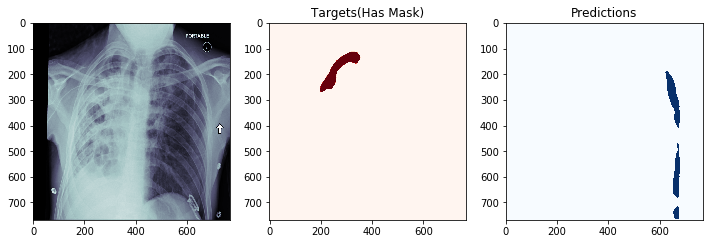

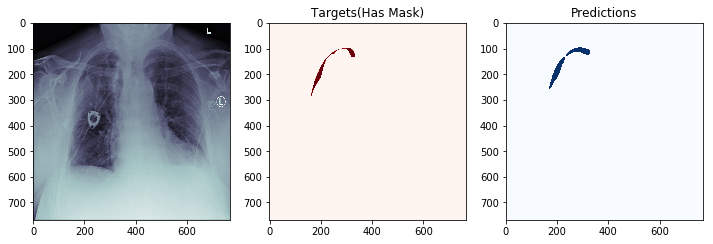

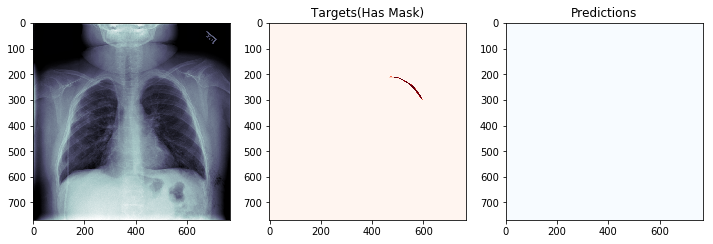

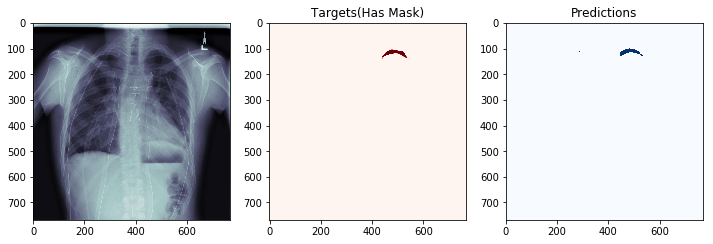

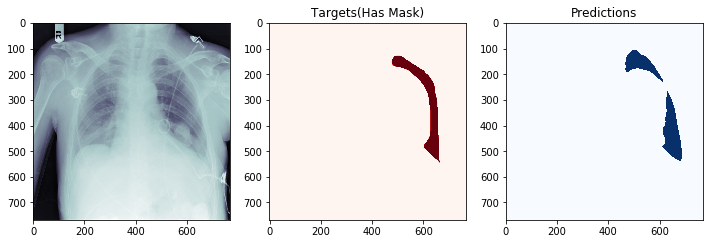

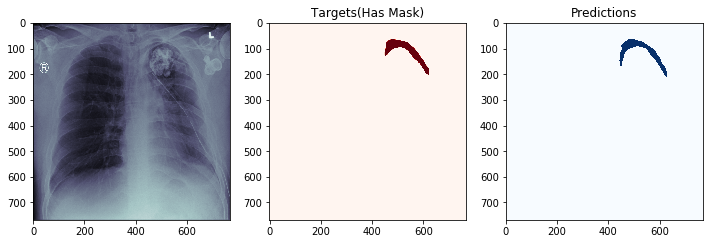

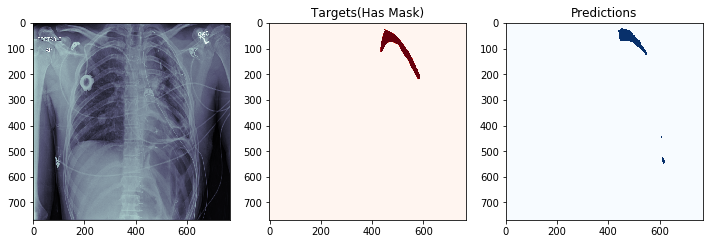

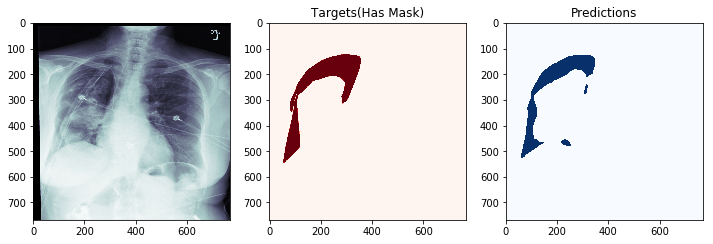

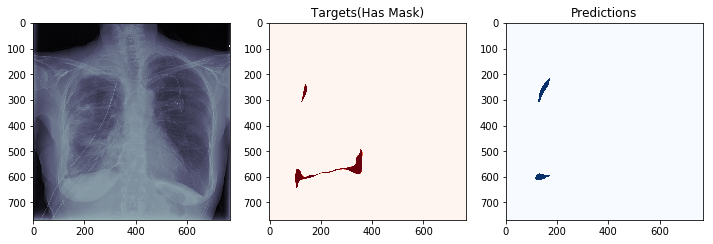

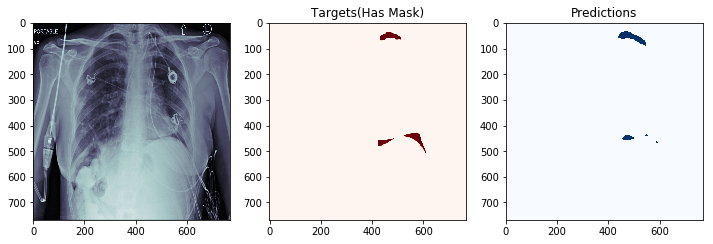

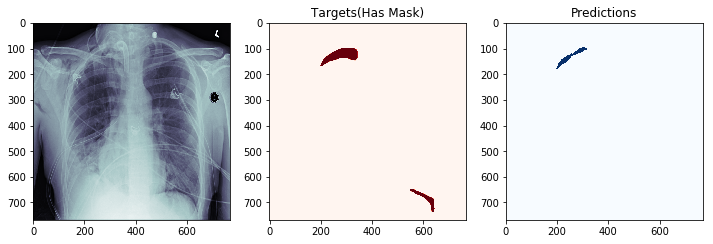

In [110]:
## visualize predicted masks
start = 0
rows = 10

cnt = 0
for idx, (img, mask) in enumerate(val_dl):
    if idx<start:
        continue
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        not_empty = mask[j][0].sum()>0
        if not_empty:
            cnt+=1
            pred_mask = predict_mask(preds_valid[idx*BATCH_SIZE+j], preds_valid_clf[idx*BATCH_SIZE+j], 
                                     CLF_THRESHOLD, MASK_THRESHOLD)
            #if pred_mask.sum()==0:
            #    continue
            fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
            ax0.imshow(img[j][0].numpy(), plt.cm.bone)
            ax1.imshow(mask[j][0], vmin=0, vmax=1, cmap="Reds")
            ax2.imshow(pred_mask, vmin=0, vmax=1, cmap="Blues")
            if not_empty.item():
                ax1.set_title('Targets(Has Mask)')
            else:
                ax1.set_title('Targets(Empty)')
            ax2.set_title('Predictions')
        if cnt>rows:
            break
    if cnt>rows:
            break

In [111]:
# cnt = 0
# for idx, (img, mask) in enumerate(val_dl):
#     if idx<start:
#         continue
#     for j in range(BATCH_SIZE):#BATCH_SIZE=8
#         not_empty = mask[j][0].sum()>0
#         if not_empty:
#             cnt+=1
#             pred_mask = predict_mask(preds_valid[idx*BATCH_SIZE+j], 0, MASK_THRESHOLD)
#             #if pred_mask.sum()==0:
#             #    continue
#             fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
#             ax0.imshow(img[j][0].numpy(), plt.cm.bone)
#             ax1.imshow(mask[j][0], vmin=0, vmax=1, cmap="Reds")
#             ax2.imshow(pred_mask, vmin=0, vmax=1, cmap="Blues")
#             if not_empty.item():
#                 ax1.set_title('Targets(Has Mask)')
#             else:
#                 ax1.set_title('Targets(Empty)')
#             ax2.set_title('Predictions')
#         if cnt>rows:
#             break
#     if cnt>rows:
#             break

In [ ]:
# ## visualize predicted masks
# rows = 20

# cnt = 0
# for idx, (img, mask) in enumerate(val_dl):
#     for j in range(BATCH_SIZE):#BATCH_SIZE=8
#         is_empty = mask[j][0].sum()==0
#         if is_empty:
#             cnt+=1
#             pred_mask = predict_mask(preds_valid[idx*BATCH_SIZE+j], EMPTY_THRESHOLD, MASK_THRESHOLD)
#             #if pred_mask.sum()==0:
#             #    continue
#             fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
#             ax0.imshow(img[j][0].numpy(), plt.cm.bone)
#             ax1.imshow(mask[j][0], vmin=0, vmax=1, cmap="Reds")
#             ax2.imshow(pred_mask, vmin=0, vmax=1, cmap="Blues")
#             if is_empty.item():
#                 ax1.set_title('Targets(Empty Mask)')
#             else:
#                 ax1.set_title('Targets(Has Mask)')
#             ax2.set_title('Predictions')
#         if cnt>rows:
#             break
#     if cnt>rows:
#             break

In [128]:
# s = (sigmoid(preds_valid)>MASK_THRESHOLD).reshape(1064, -1).sum(axis=1)
# (s>1420).mean(), (s>0).mean()

## predict the testset

In [112]:
import glob
from dataset_unet import prepare_testset

In [113]:
test_fnames = [f.split('/')[-1][:-4] for f in glob.glob('data/processed/test/*')]
len(test_fnames), test_fnames[0]

(1377, '1.2.276.0.7230010.3.1.4.8323329.6160.1517875196.806852')

In [114]:
test_dl = prepare_testset(BATCH_SIZE, NUM_WORKERS, IMG_SIZE)

In [120]:
%%time
clf.set_mode('valid')#.module
preds_test_clf = clf_predict_proba(clf, test_dl, device, multi_gpu=False, mode='test', tta=True)

/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


CPU times: user 5min 15s, sys: 46.9 s, total: 6min 2s
Wall time: 1min 48s


In [121]:
preds_test_clf.shape

(1377, 1)

In [117]:
%%time
preds_test = mask_predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)

use TTA
CPU times: user 10min 18s, sys: 3min 40s, total: 13min 58s
Wall time: 2min 58s


In [118]:
preds_test.shape

(1377, 768, 768)

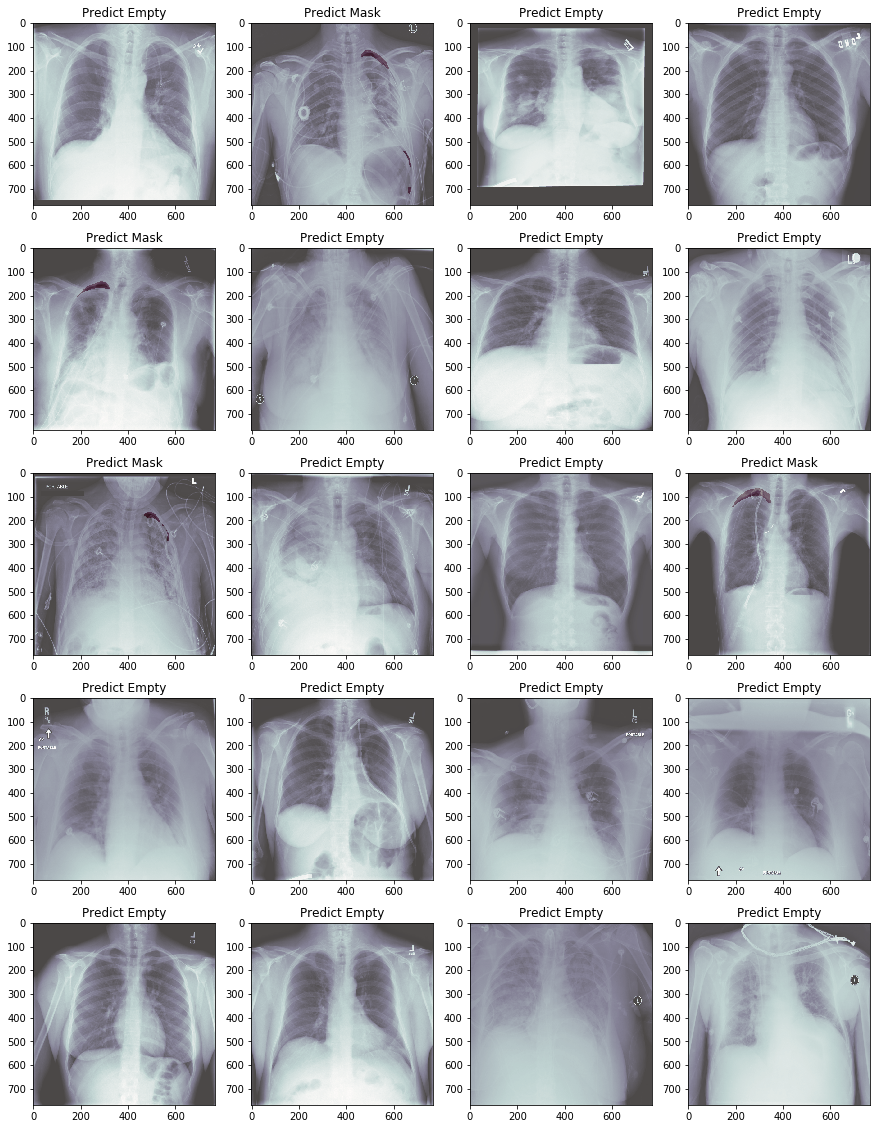

In [122]:
## visualize predicted masks
start = 0
total = 19

fig=plt.figure(figsize=(15, 20))
cnt = 0
for idx, img in enumerate(test_dl):
    if idx<start:
        continue
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        cnt+=1
        #pred_mask = predict_mask(preds_test[idx*BATCH_SIZE+j], EMPTY_THRESHOLD, MASK_THRESHOLD)
        pred_mask = predict_mask(preds_test[idx*BATCH_SIZE+j], preds_test_clf[idx*BATCH_SIZE+j], 
                                 CLF_THRESHOLD, MASK_THRESHOLD)
        #if pred_mask.float().mean()==0:
        #    continue
        ax = fig.add_subplot(5, 4, cnt)
        plt.imshow(img[j][0].numpy(), plt.cm.bone)
        plt.imshow(pred_mask, alpha=0.3, cmap="Reds")
        if pred_mask.sum()>0:
            plt.title('Predict Mask')
        else:
            plt.title('Predict Empty')
        if cnt>total:
            break
    if cnt>total:
            break

In [127]:
#pred_clf = (sigmoid(preds_test_clf)>CLF_THRESHOLD).astype(np.int)
#print('predict clf=1 percentage: ', round(pred_clf.mean(), 3))

## build submission

In [129]:
import PIL
from mask_functions import mask2rle

In [133]:
%%time
#### Step 1: Generate rle encodings (images are first converted to the original size)
rles = []
N = preds_test.shape[0]
for idx in tqdm_notebook(range(N)):#p is logit from model
    #pred_mask = predict_mask(p, EMPTY_THRESHOLD, MASK_THRESHOLD)
    pred_mask = predict_mask(preds_test[idx], preds_test_clf[idx], CLF_THRESHOLD, MASK_THRESHOLD)
    if pred_mask.sum()>0:#predicted non-empty mask
        im = PIL.Image.fromarray((pred_mask.T*255).astype(np.uint8)).resize((1024,1024))
        im = np.asarray(im)
        rles.append(mask2rle(im, 1024, 1024))
    else: rles.append('-1')
    
sub_df = pd.DataFrame({'ImageId': test_fnames, 'EncodedPixels': rles})
print(len(sub_df.index))
sub_df.head()

1377
CPU times: user 22min 18s, sys: 1min 18s, total: 23min 37s
Wall time: 2min 30s


In [132]:
preds_test.shape, preds_test_clf.shape

((1377, 768, 768), (1377, 1))

In [134]:
sub_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,631992 5 1019 5 1015 11 1012 13 1008 16 1008 1...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,253201 3 1020 4 1019 5 1019 5 1016 9 1014 9 10...


In [136]:
# check the correctness of transformation
pred_mask = predict_mask(preds_test[22], preds_test_clf[22], CLF_THRESHOLD, MASK_THRESHOLD)
im = PIL.Image.fromarray((pred_mask.T*255).astype(np.uint8)).resize((1024,1024))
im = np.asarray(im)
im.max()

255

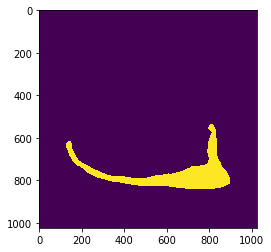

In [137]:
plt.imshow(im)

In [139]:
sub_df.to_csv('submission/0804_deeplabv3plus_768_seed1234_tta_v1_with_classifier.csv.gz', index=False, compression='gzip')

In [138]:
(sub_df.EncodedPixels!='-1').mean()

0.2178649237472767

In [52]:
rd_mask = np.zeros((1024, 1024))
d = 50
rd_mask[400:400+d, 400:400+d] = 1.0

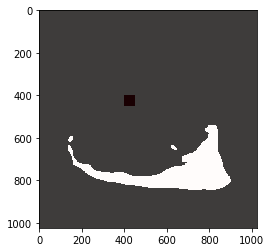

In [53]:
plt.imshow(im, cmap=plt.cm.bone)
plt.imshow(rd_mask, alpha=0.25, cmap='Reds')